In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import Holt
import statsmodels.graphics.tsaplots as tsa_plots
import warnings 
warnings.filterwarnings('ignore')

In [77]:
data=pd.read_excel("C:\\Users\\lenovo\\OneDrive\\data science\\assignment\\Forecasting\\CocaCola_Sales_Rawdata.xlsx")
data.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [3]:
data.isnull().sum()

Quarter    0
Sales      0
dtype: int64

In [4]:
data.duplicated().sum()

0

Text(0.5, 1.0, 'Sales')

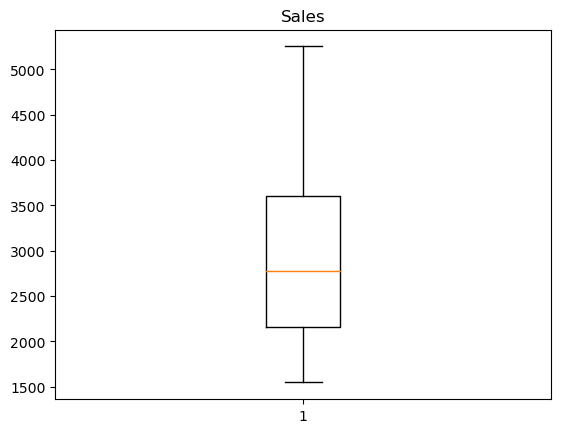

In [5]:
plt.boxplot(data.Sales);
plt.title('Sales')

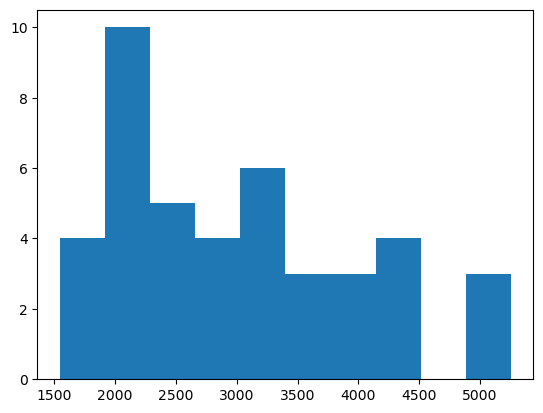

In [6]:
plt.hist(data.Sales);

<AxesSubplot:>

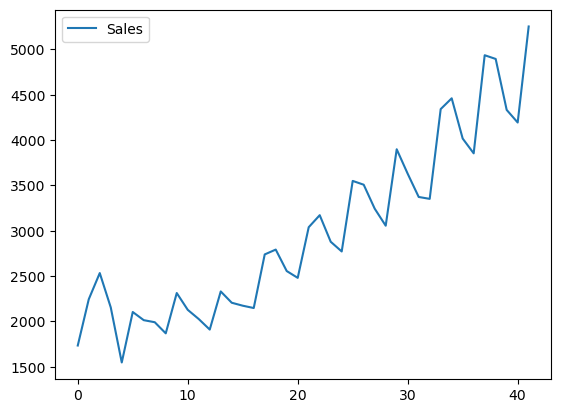

In [7]:
data.plot()

<AxesSubplot:xlabel='Sales', ylabel='Density'>

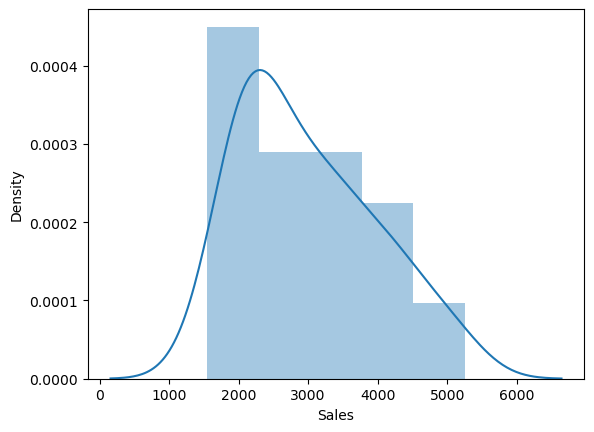

In [8]:
sns.distplot(data.Sales)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

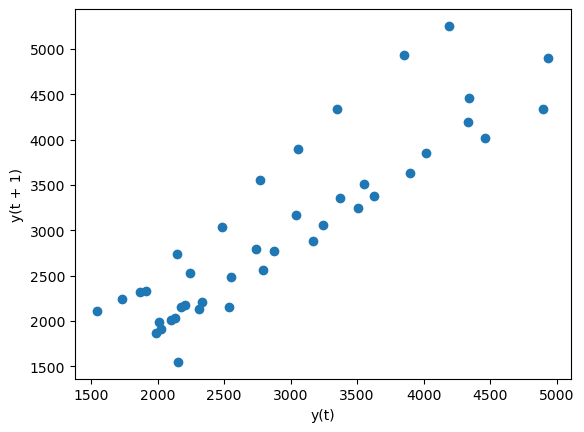

In [9]:
from pandas.plotting import lag_plot
lag_plot(data.Sales)

In [10]:
data['quarters']=0
for i in range(42):
    a=data['Quarter'][i]
    data['quarters'][i]=a[0:2]

In [11]:
data['year']=0
for i in range(42):
    a=data['Quarter'][i]
    b=a[3:]
    data['year'][i]='19'+b

In [12]:
#data

In [13]:
data1=pd.DataFrame(pd.get_dummies(data.quarters),columns=['Q1','Q2','Q3','Q4'])
df=pd.concat([data,data1],axis=1)
df.head()

,Quarter,Sales,quarters,year,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1,1986,1,0,0,0
1,Q2_86,2244.960999,Q2,1986,0,1,0,0
2,Q3_86,2533.804993,Q3,1986,0,0,1,0
3,Q4_86,2154.962997,Q4,1986,0,0,0,1
4,Q1_87,1547.818996,Q1,1987,1,0,0,0


In [14]:
df['t'] = np.arange(1,43)
df['t_squared'] = df['t']**2
df["Sales_log"] =np.log(df['Sales'])
df.head()

,Quarter,Sales,quarters,year,Q1,Q2,Q3,Q4,t,t_squared,Sales_log
0,Q1_86,1734.827000,Q1,1986,1,0,0,0,1,1,7.458663
1,Q2_86,2244.960999,Q2,1986,0,1,0,0,2,4,7.716443
2,Q3_86,2533.804993,Q3,1986,0,0,1,0,3,9,7.837477
3,Q4_86,2154.962997,Q4,1986,0,0,0,1,4,16,7.675529
4,Q1_87,1547.818996,Q1,1987,1,0,0,0,5,25,7.344602


<AxesSubplot:xlabel='quarters', ylabel='year'>

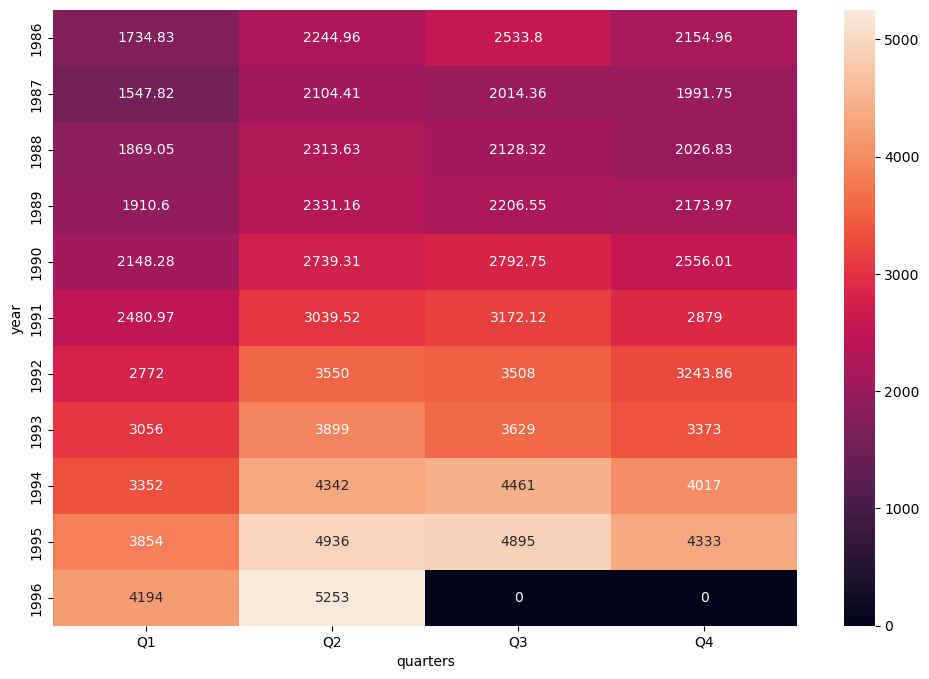

In [15]:
plt.figure(figsize=(12,8))
heatmap_y_month = pd.pivot_table(data=df,values="Sales",index="year",columns="quarters",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g")

<AxesSubplot:xlabel='year', ylabel='Sales'>

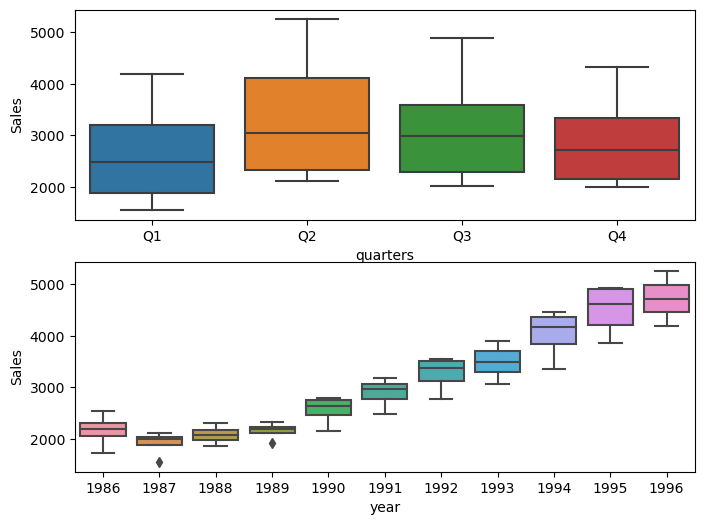

In [16]:
# Boxplot for ever
plt.figure(figsize=(8,6))
plt.subplot(211)
sns.boxplot(x="quarters",y="Sales",data=df)
plt.subplot(212)
sns.boxplot(x="year",y="Sales",data=df)

In [17]:
# model based method

In [78]:
# splitting the data
Train=df.head(30)
Test=df.tail(12)
Test

,Quarter,Sales,quarters,year,Q1,Q2,Q3,Q4,t,t_squared,Sales_log
30,Q3_93,3629.0,Q3,1993,0,0,1,0,31,961,8.196712
31,Q4_93,3373.0,Q4,1993,0,0,0,1,32,1024,8.123558
32,Q1_94,3352.0,Q1,1994,1,0,0,0,33,1089,8.117312
33,Q2_94,4342.0,Q2,1994,0,1,0,0,34,1156,8.376090
34,Q3_94,4461.0,Q3,1994,0,0,1,0,35,1225,8.403128
35,Q4_94,4017.0,Q4,1994,0,0,0,1,36,1296,8.298291
36,Q1_95,3854.0,Q1,1995,1,0,0,0,37,1369,8.256867
37,Q2_95,4936.0,Q2,1995,0,1,0,0,38,1444,8.504311
38,Q3_95,4895.0,Q3,1995,0,0,1,0,39,1521,8.495970
39,Q4_95,4333.0,Q4,1995,0,0,0,1,40,1600,8.374015


In [19]:
linear=smf.ols('Sales~t',data=Train).fit()
yp_linear=pd.Series(linear.predict(pd.DataFrame(Test.t)))
rmse_linear=np.sqrt(np.mean(np.array(Test.Sales)-np.array(yp_linear))**2)
rmse_linear

545.5139554447713

In [20]:
Exp_model=smf.ols('Sales_log~t',data=Train).fit()
predict_exp=pd.Series(Exp_model.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(predict_exp)))**2))
rmse_Exp

552.2821039079295

In [21]:
Quad = smf.ols('Sales~t+t_squared',data=Train).fit()
predict_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(predict_Quad))**2))
rmse_Quad

646.2715428311323

In [22]:
add_sea = smf.ols('Sales~Q1+Q2+Q3',data=Train).fit()
predict_add_sea = pd.Series(add_sea.predict(Test[['Q1','Q2','Q3']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(predict_add_sea))**2))
rmse_add_sea = round(rmse_add_sea,2)
rmse_add_sea

1778.01

In [23]:
add_sea_Qua = smf.ols('Sales~t+t_squared+Q1+Q2+Q3',data=Train).fit()
predict_add_sea = pd.Series(add_sea_Qua.predict(Test[['t','t_squared','Q1','Q2','Q3']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(predict_add_sea))**2))
rmse_add_sea_quad = round(rmse_add_sea_quad,2)
rmse_add_sea_quad

586.05

In [24]:
#Multiplicative Seasonality

Mul_sea = smf.ols('Sales_log~Q1+Q2+Q3',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea = round(rmse_Mult_sea,2)
rmse_Mult_sea

1828.92

In [25]:
#Multiplicative Additive Seasonality 

#Multiplicative Additive Seasonality 

Mul_Add_sea = smf.ols('Sales_log~t+Q1+Q2+Q3',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea = round(rmse_Mult_add_sea,2)
rmse_Mult_add_sea

410.25

In [26]:
data1 = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data1)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
6,rmse_Mult_add_sea,410.250000
0,rmse_linear,545.513955
1,rmse_Exp,552.282104
4,rmse_add_sea_quad,586.050000
2,rmse_Quad,646.271543
3,rmse_add_sea,1778.010000
5,rmse_Mult_sea,1828.920000


# Multiplicative Additive Seasonality has low rmse values,so we bulid final modal on that.

In [30]:
y_mul_add = Test.copy()
Mul_Add_sea = smf.ols('Sales_log~t+Q1+Q2+Q3',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
y_mul_add['mul_add_sea'] = np.exp(Mul_Add_sea.predict(Test))
y_mul_add['mul_sea_forecast']=np.exp(Mul_sea.predict(Test))
y_mul_add['linear_predict']=linear.predict(Test)
y_mul_add['exponential']=np.exp(Exp_model.predict(Test))
y_mul_add['Quadratic']=add_sea_Qua.predict(Test)
y_mul_add['Additive_sea']=add_sea.predict(Test)

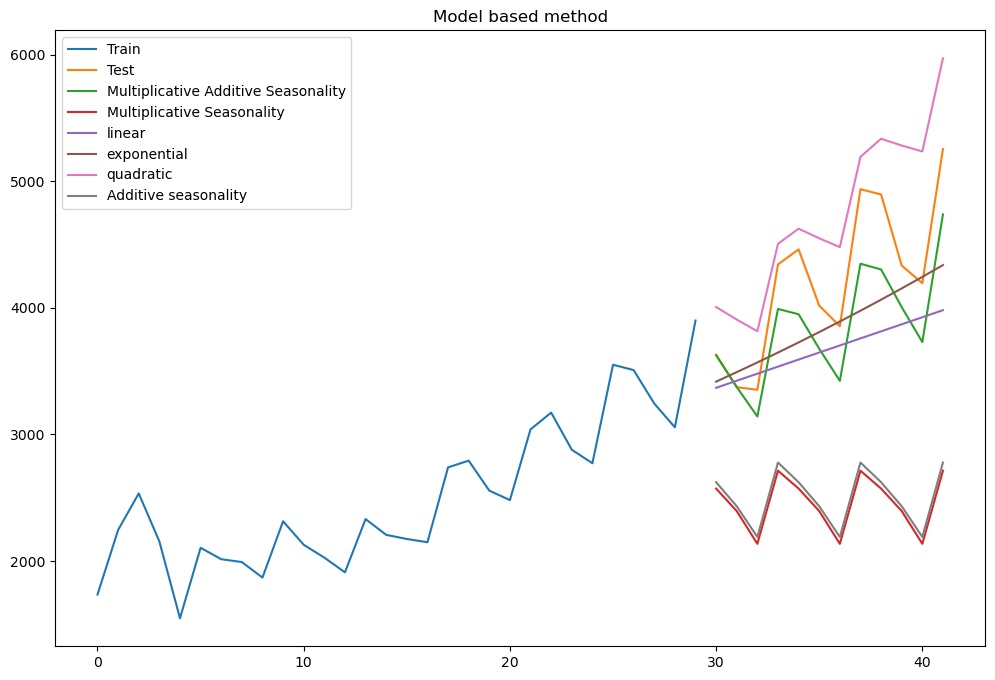

In [31]:
plt.figure(figsize = (12,8))
plt.plot(Train['Sales'], label = 'Train')
plt.plot(Test['Sales'], label = 'Test')
plt.plot(y_mul_add['mul_add_sea'], label ='Multiplicative Additive Seasonality')
plt.plot(y_mul_add['mul_sea_forecast'], label ='Multiplicative Seasonality')
plt.plot(y_mul_add['linear_predict'], label ='linear')
plt.plot(y_mul_add['exponential'], label ='exponential')
plt.plot(y_mul_add['Quadratic'], label ='quadratic')
plt.plot(y_mul_add['Additive_sea'], label ='Additive seasonality')
plt.legend(loc = 'best')
plt.title('Model based method')
plt.show()

### As from the rmse and from above line plot we can see that Multiplicative Additive Seasonality has low rmse,model is predicting values close the test values


In [32]:
# arima model

In [33]:
df2=pd.read_excel("C:\\Users\\lenovo\\OneDrive\\data science\\assignment\\Forecasting\\CocaCola_Sales_Rawdata.xlsx")
df2.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


<AxesSubplot:>

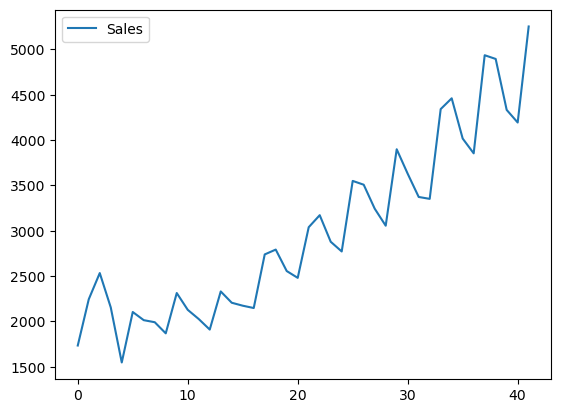

In [34]:
df2.plot()

### from above plot we can see the given sales data has upper linear trend and seasonality which is non-stationary  data,we can confirm by dickey fuller test

array([[<AxesSubplot:title={'center':'Sales'}>]], dtype=object)

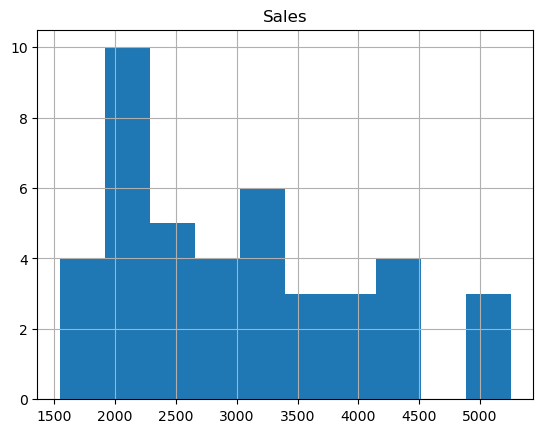

In [35]:
df2.hist()

## From above histogram plot we see that sales data is skewed which doesnt have constant variance and constant mean

In [36]:
X = df2
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=2190.682807, mean2=3798.023809
variance1=97608.117624, variance2=506545.822521


# by spllting the dataset into checking the mean and variance,
# we can see that both mean and variance values from splits have more variation in values


# log Transformation

In [39]:
df2_log=np.log(df2.Sales)


<AxesSubplot:>

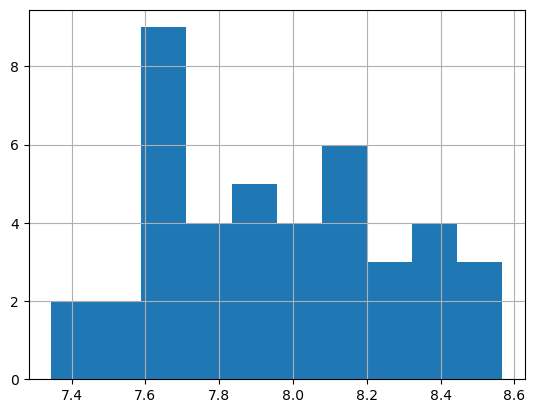

In [40]:
df2_log.hist()

In [41]:
X = df2_log
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=7.682118, mean2=8.225891
variance1=0.020957, variance2=0.034021


### by spllting the dataset into checking the mean and variance,we can see that both mean and variance values from splits
### we can see that values are very close after transformation

# adfuller test

In [43]:
result=adfuller(df2_log)
print('P-value',result[1])

result=adfuller(df2_log.diff().dropna())#1st order differencing
print('P-value',result[1])

P-value 0.9718560271303519
P-value 0.02054758887892842


# determining the differencing order 'd'.

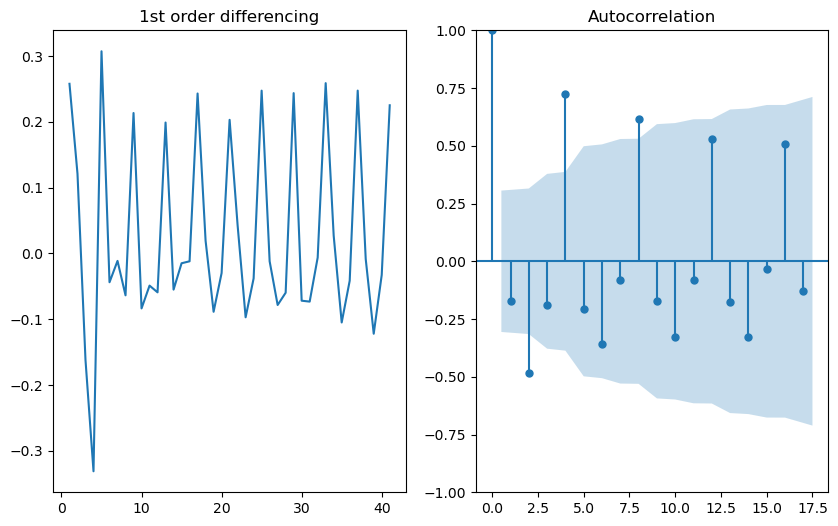

In [45]:
plot=plt.figure(figsize=(10,6))
ax1=plot.add_subplot(121)
ax1.set_title('1st order differencing')
ax1.plot(df2_log.diff())
ax2=plot.add_subplot(122)
plot_acf(df2_log.diff().dropna(),ax=ax2)
plt.show()

In [ ]:
# from above plot we can see geomtric decay q=2

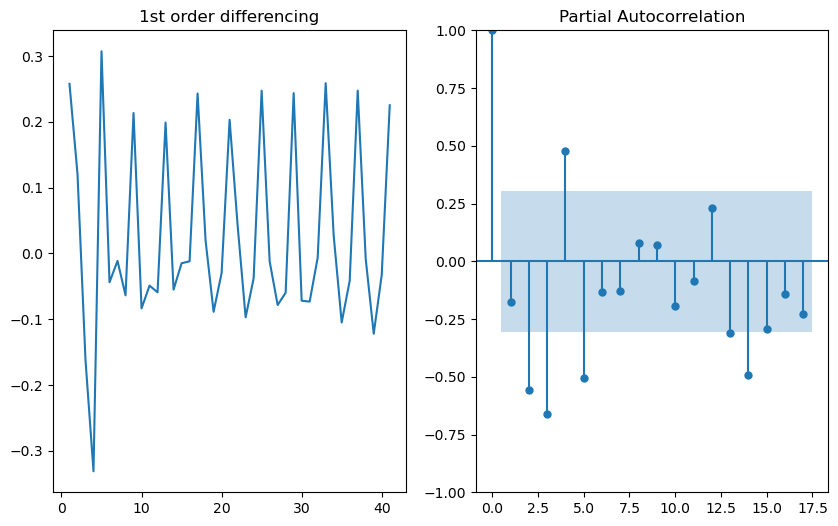

In [46]:
plot=plt.figure(figsize=(10,6))
ax1=plot.add_subplot(121)
ax1.set_title('1st order differencing')
ax1.plot(df2_log.diff())
ax2=plot.add_subplot(122)
plot_pacf(df2_log.diff().dropna(),ax=ax2)
plt.show()

# pacf gives AR(p=4),d=1,acf-q=2 for 1st order differencing

# ARIMA MODEL

In [89]:
df2['Sales_log']=np.log(df2.Sales)

In [106]:
from statsmodels.tsa.arima.model import ARIMA
arima_model=ARIMA(df2.Sales_log,order=(4,1,2))
model=arima_model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:              Sales_log   No. Observations:                   42
Model:                 ARIMA(4, 1, 2)   Log Likelihood                  52.196
Date:                Tue, 06 Dec 2022   AIC                            -90.392
Time:                        16:16:54   BIC                            -78.397
Sample:                             0   HQIC                           -86.024
                                 - 42                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1226      0.145     -0.847      0.397      -0.406       0.161
ar.L2         -0.0390      0.157     -0.249      0.803      -0.346       0.268
ar.L3          0.0071      0.142      0.050      0.9

### from summary,we can see that for given pdq order(4,1,2),aic is very low
### aic tell us the how well model fits the data,lower the aic better the model

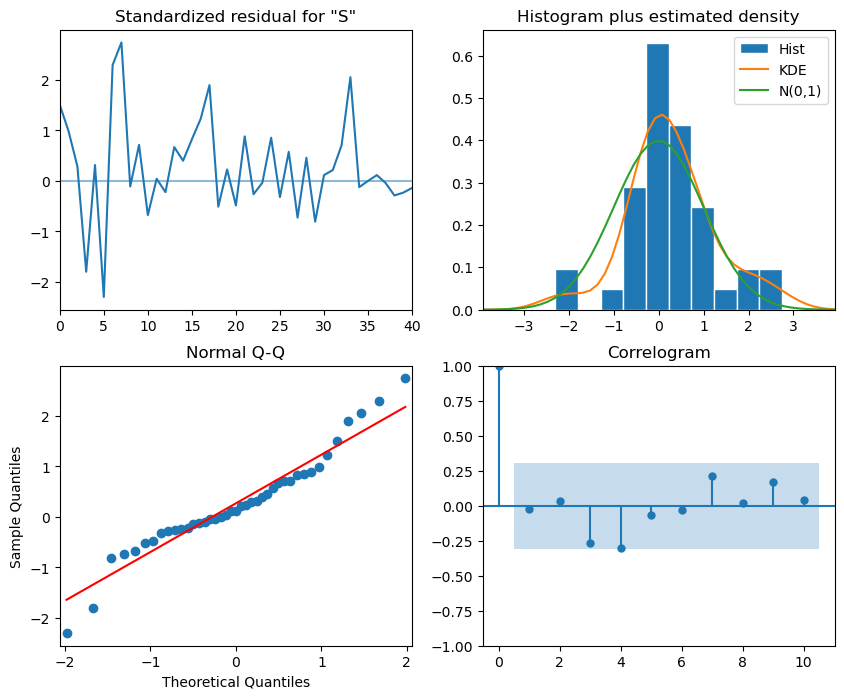

In [108]:
model.plot_diagnostics(figsize=(10,8))
plt.show()

Text(0.5, 1.0, 'Sales and forecasted values')

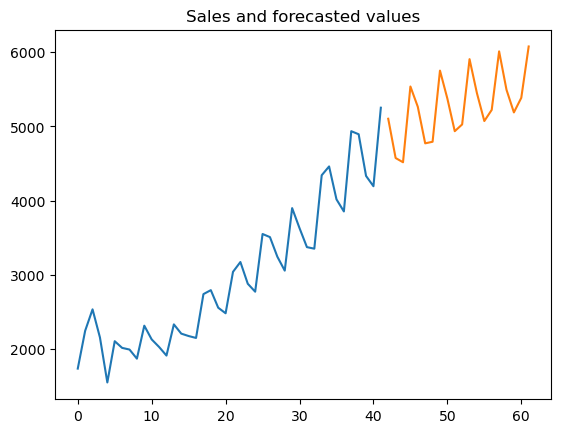

In [131]:
plt.plot(df2.Sales)
plt.plot(np.exp(model.forecast(20)))
plt.title('Sales and forecasted values')


# Moving average

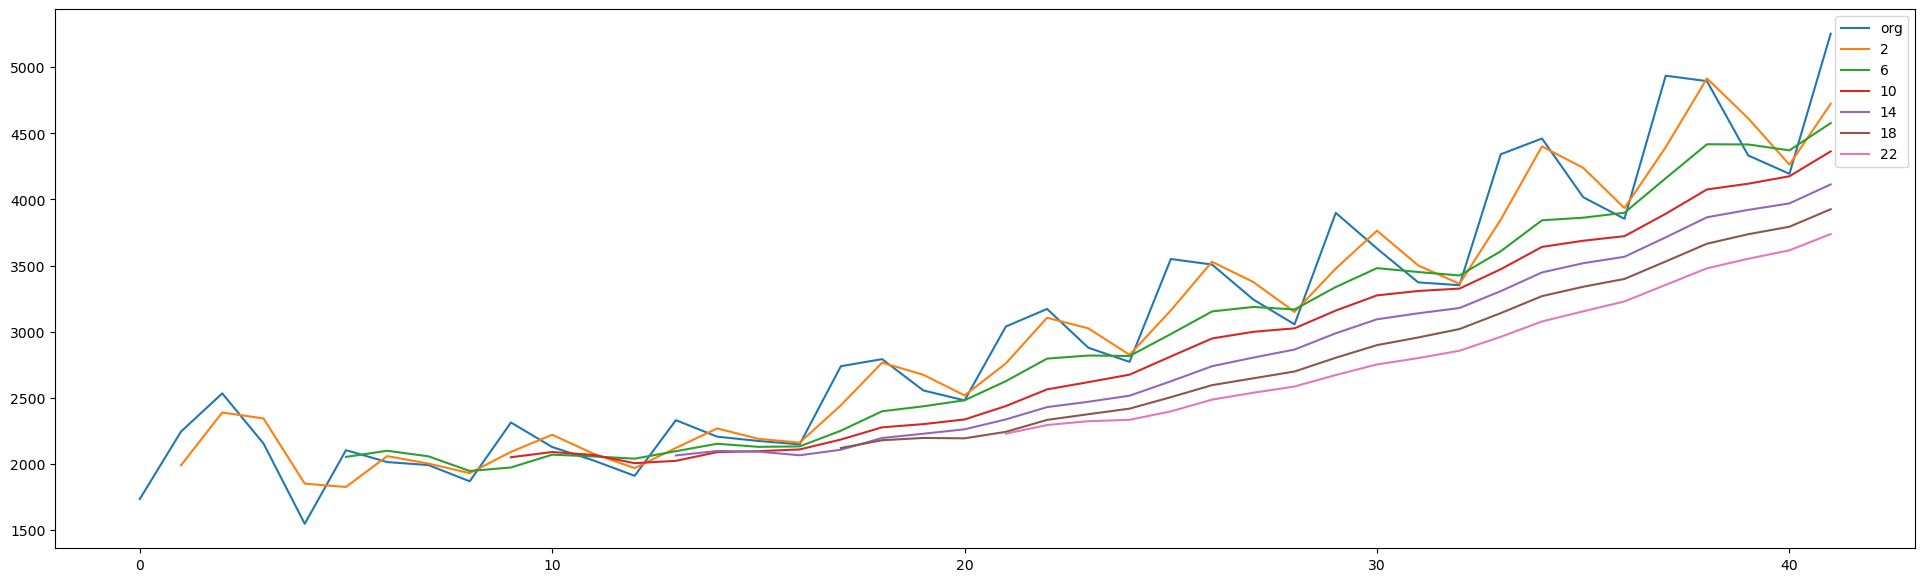

In [133]:
plt.figure(figsize=(24,7))
data.Sales.plot(label='org')
for i in range(2,24,4):
    data['Sales'].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

### from above plot we can see that as the window size increases the trend is getting decreased

# data driven methods-smoothing

### Seasonal decomposition,to check the data is stationary or not stationary

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import Holt
import statsmodels.graphics.tsaplots as tsa_plots

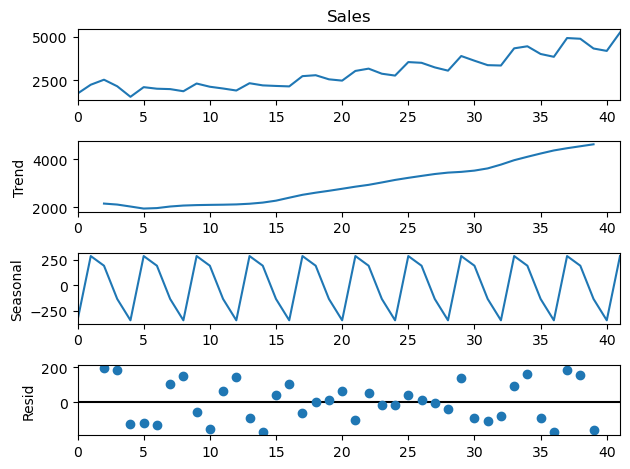

In [134]:
decompose_ts=seasonal_decompose(df2.Sales,period=4)
decompose_ts.plot()
plt.show()

##  Mean absolutes percentage error

In [137]:
def MAPE(pred,orb):
    temp=np.abs((pred-orb)/orb)*100
    return np.mean(temp)

## Simple Exponential smoothing

In [143]:
ses_model=SimpleExpSmoothing(Train.Sales).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_ses,Test.Sales) 

22.046763674416013

## Holt method

In [144]:
holt_model=Holt(Train.Sales).fit(smoothing_level=0.2,smoothing_trend=0.2)
pred_holt = holt_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_holt,Test.Sales) 

8.8896553695096

## holt winters exponential smoothing additive seasonality and additive trend

In [146]:
hwe_model_add_add = ExponentialSmoothing(Train["Sales"],seasonal="add",trend="add",seasonal_periods=4).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_add_add,Test.Sales) 

4.754434383376265

## holt winters exponential smoothing multiplicative seasonality and additive trend

In [147]:
hwe_model_add_add = ExponentialSmoothing(Train["Sales"],seasonal="mul",trend="add",seasonal_periods=4).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_add_add,Test.Sales) 

4.005589950991054

### Mean absolute error is less for holt winters exponential smoothing multiplicative seasonality and additive trend

In [148]:
y_hat_hwm = Test.copy()
model = ExponentialSmoothing(np.array(Train['Sales']), seasonal_periods=12, trend = 'add', seasonal= 'mul')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwm['hwm_sales'] = model_fit.forecast(12)

{'smoothing_level': 0.7465110991647694, 'smoothing_trend': 0.0010987958850575334, 'smoothing_seasonal': 0.18115221646398402, 'damping_trend': nan, 'initial_level': 1970.3839045940438, 'initial_trend': 41.44218077494405, 'initial_seasons': array([0.93884238, 1.1576741 , 1.15559137, 1.05287382, 0.92571835,
       1.16140626, 1.12404483, 1.02617507, 0.9610899 , 1.16227357,
       1.12898721, 1.00716594]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


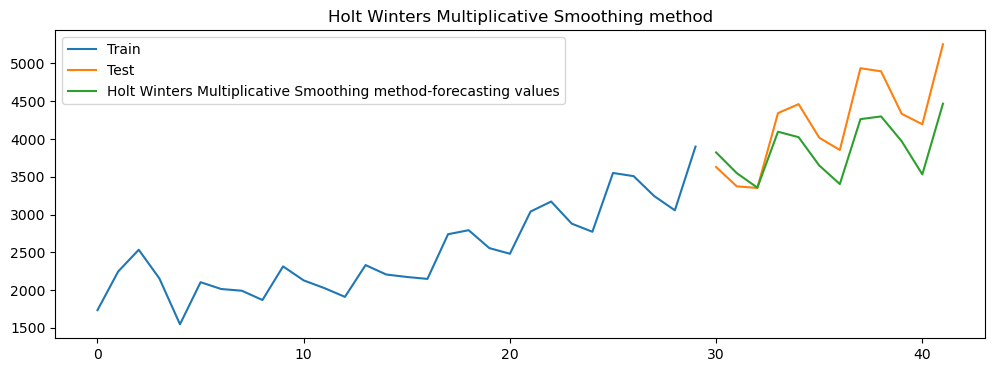

In [152]:
plt.figure(figsize = (12,4))
plt.plot(Train['Sales'], label = 'Train')
plt.plot(Test['Sales'], label = 'Test')
plt.plot(y_hat_hwm['hwm_sales'], label ='Holt Winters Multiplicative Smoothing method-forecasting values')
plt.legend(loc = 'best')
plt.title('Holt Winters Multiplicative Smoothing method')
plt.show()